[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/LNHunter/blob/master/binary_classification.ipynb)

# Binary classification

## Data loading and preparation

In [1]:
import numpy as np
import pandas as pd

import os
import pickle

data_dir  = "./data"
data_file = "db_mediastinalbulky_v2-reduced.pkl" 
file_path = os.path.join ( data_dir, data_file )

with open (file_path, "rb") as file:
  data = pickle.load (file)

data . info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 0 to 118
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               119 non-null    float64
 1   lymphoma_type                    119 non-null    float64
 2   age                              111 non-null    float64
 3   SUVmin (SUV)                     111 non-null    float64
 4   SUVmean (SUV)                    111 non-null    float64
 5   MTV (# vx)                       111 non-null    float64
 6   SMTV (mL/Kg) TOT                 111 non-null    float64
 7   CONVENTIONAL_SUVbwmin            115 non-null    float64
 8   CONVENTIONAL_SUVbwKurtosis       115 non-null    float64
 9   DISCRETIZED_HISTO_Kurtosis       110 non-null    float64
 10  SHAPE_Sphericity[onlyFor3DROI])  113 non-null    float64
 11  GLCM_Correlation                 113 non-null    float64
 12  GLRLM_SRE             

### Aggressive data cleaning 

In [2]:
data . dropna ( inplace = True )
data . info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 118
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               101 non-null    float64
 1   lymphoma_type                    101 non-null    float64
 2   age                              101 non-null    float64
 3   SUVmin (SUV)                     101 non-null    float64
 4   SUVmean (SUV)                    101 non-null    float64
 5   MTV (# vx)                       101 non-null    float64
 6   SMTV (mL/Kg) TOT                 101 non-null    float64
 7   CONVENTIONAL_SUVbwmin            101 non-null    float64
 8   CONVENTIONAL_SUVbwKurtosis       101 non-null    float64
 9   DISCRETIZED_HISTO_Kurtosis       101 non-null    float64
 10  SHAPE_Sphericity[onlyFor3DROI])  101 non-null    float64
 11  GLCM_Correlation                 101 non-null    float64
 12  GLRLM_SRE             

### Splitting into train-set and test-set

In [3]:
cols = list ( data.columns )
X_cols = cols[2:]
y_cols = "lymphoma_type"

binary_class = (data[y_cols] != 2)   # exclude GZ class

X = data[binary_class][X_cols] . to_numpy()
y = data[binary_class][y_cols] . to_numpy() . flatten()

ratio = len(y[y == 3]) / len(y[y == 1])
print ( "Label ratio on data-set : {:.1f}%" . format (100 * ratio) )

Label ratio on data-set : 41.5%


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split ( X, y, test_size = 0.2, random_state = 42 )

ratio_train = len(y_train[y_train == 3]) / len(y_train[y_train == 1])
print ( "Label ratio on train-set : {:.1f}%" . format (100 * ratio_train) )

ratio_test = len(y_test[y_test == 3]) / len(y_test[y_test == 1])
print ( "Label ratio on test-set  : {:.1f}%" . format (100 * ratio_test) )

Label ratio on train-set : 46.0%
Label ratio on test-set  : 26.7%


In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit ( n_splits = 1, test_size = 0.2, random_state = 42 )
for idx_train, idx_test in sss . split ( X, y ):
  X_train , y_train = X[idx_train] , y[idx_train]
  X_test  , y_test  = X[idx_test]  , y[idx_test]

ratio_train = len(y_train[y_train == 3]) / len(y_train[y_train == 1])
print ( "Label ratio on train-set : {:.1f}%" . format (100 * ratio_train) )

ratio_test = len(y_test[y_test == 3]) / len(y_test[y_test == 1])
print ( "Label ratio on test-set  : {:.1f}%" . format (100 * ratio_test) )

Label ratio on train-set : 40.4%
Label ratio on test-set  : 46.2%


### Data preprocessing

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#scaler = MinMaxScaler()
scaler = StandardScaler()

X_train = scaler . fit_transform ( X_train )
X_test  = scaler . transform ( X_test )

## Dummy Classifier

In [7]:
from utils import DummyClassifier

clf_dummy = DummyClassifier()

In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score ( clf_dummy, X_train, y_train, scoring = "accuracy", cv = 3 )

def display_score ( model_name: str, scores: list ):
  str_len = len ( model_name )
  print ( "+--" + "-" * str_len + "--+")
  print ( "|  {}  |" . format (model_name) )
  print ( "+--" + "-" * str_len + "--+")
  print ( "| Accuracy : {}" . format ( scores ) )
  print ( "| Mean : {:.1f}%" . format ( 100 * np.mean(scores) ) )
  print ( "| Std  : {:.1f}%" . format ( 100 * np.std (scores) ) )
  print ( "+--- - -")

display_score ( model_name = "Dummy Classifier", scores = scores )

+--------------------+
|  Dummy Classifier  |
+--------------------+
| Accuracy : [0.68       0.5        0.41666667]
| Mean : 53.2%
| Std  : 11.0%
+--- - -


+---->  Label HL   <----+
|   Precision : 68.0%   |
|   Recall    : 65.4%   |
+---->  Label PML  <----+
|   Precision : 21.7%   |
|   Recall    : 23.8%   |
+-----------------------+


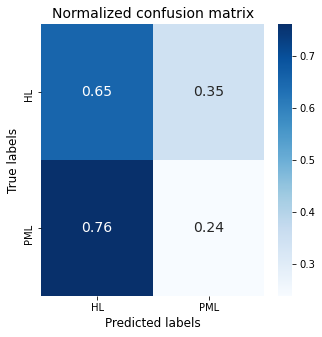

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_predict
from sklearn.metrics         import confusion_matrix

y_train_pred = cross_val_predict ( clf_dummy, X_train, y_train, cv = 3 )


def precision_recall_scores ( 
                              y_true  : np.ndarray , 
                              y_pred  : np.ndarray ,
                              verbose : bool = False ,
                              labels  : list = None , 
                              show_conf_matrix : bool = False ,
                              normalization : bool = False ,
                            ):
  if labels is not None:
    if len(labels) != len(np.unique(y_true)):
      raise ValueError ( "Labels list length doesn't match with the true number of classes." )
  else:
    labels = np.unique ( y_true )

  conf_matrix = confusion_matrix ( y_train, y_train_pred )
  precision = np.zeros ( len(conf_matrix) )
  recall    = np.zeros ( len(conf_matrix) )

  for i in range ( len(conf_matrix) ):
    precision[i] = conf_matrix[i,i] / np.sum ( conf_matrix[:,i] )
    recall[i]    = conf_matrix[i,i] / np.sum ( conf_matrix[i,:] )
    if verbose:
      print ( "+---->  Label {:3}  <----+" . format (labels[i]) )
      print ( "|   Precision : {:.1f}%   |" . format (100 * precision[i]) )
      print ( "|   Recall    : {:.1f}%   |" . format (100 * recall[i])    )
  if verbose: print ( "+-----------------------+" )

  if show_conf_matrix:
    plt.figure ( figsize = (5,5) )
    if normalization:
      plt.title ( "Normalized confusion matrix", fontsize = 14 )
      conf_matrix = conf_matrix / np.sum ( conf_matrix, axis = 1 ) [:,None]
    else:
      plt.title ( "Confusion matrix", fontsize = 14 )
    conf_matrix = pd.DataFrame (conf_matrix, index = labels, columns = labels )
    sns.heatmap ( conf_matrix, annot = True, annot_kws = { "size" : 14 }, cmap = "Blues" )
    plt.xlabel ( "Predicted labels", fontsize = 12 )
    plt.ylabel ( "True labels", fontsize = 12)
    plt.show()

  return precision, recall


_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True, normalization = True )


## Logistic Regression

+-----------------------+
|  Logistic Regression  |
+-----------------------+
| Accuracy : [0.88       0.66666667 0.83333333]
| Mean : 79.3%
| Std  : 9.2%
+--- - -
+---->  Label HL   <----+
|   Precision : 89.4%   |
|   Recall    : 80.8%   |
+---->  Label PML  <----+
|   Precision : 61.5%   |
|   Recall    : 76.2%   |
+-----------------------+


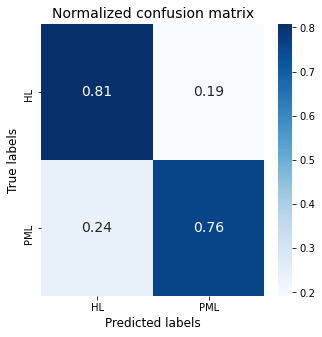

In [10]:
from sklearn.linear_model import LogisticRegression

clf_logistic = LogisticRegression ( 
                                    penalty = "l2" ,
                                    class_weight = "balanced" ,
                                    solver = "liblinear" ,
                                    max_iter = 500 ,
                                    multi_class = "ovr" ,
                                  )

scores = cross_val_score ( clf_logistic, X_train, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_logistic, X_train, y_train, cv = 3 )

display_score ( model_name = "Logistic Regression", scores = scores )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True, normalization = True )

### Automatic hyperparameters tuning

In [11]:
import optuna
optuna.logging.set_verbosity ( optuna.logging.ERROR )   # silence Optuna during trials study

### Return a set of trials studied by Optuna
def optuna_study (
                   model_name  : str ,
                   storage_dir : str ,
                   objective   : float ,
                   n_trials    : int = 10 ,
                   direction : str = "minimize"  , 
                   load_if_exists : bool = False ,
                 ):
  storage_path = "{}/{}.db" . format (storage_dir, model_name)
  storage_name = "sqlite:///{}" . format (storage_path)  

  if load_if_exists:
    pass
  elif not ( load_if_exists ) and os.path.isfile ( storage_path ):
    os.remove ( storage_path )

  study = optuna.create_study ( 
                                study_name = model_name ,
                                storage  = storage_name ,
                                load_if_exists = load_if_exists ,
                                direction = direction
                              )

  study . optimize ( objective, n_trials = n_trials )

  return study

In [12]:
def obj_logistic (trial):
  c_weights = trial . suggest_categorical ( "c_weights" , [None, "balanced"] )
  solver    = trial . suggest_categorical ( "solver", ["lbfgs", "liblinear"] )
  max_iter  = trial . suggest_int ( "max_iter", 500, 1000, log = True )

  model = LogisticRegression ( 
                               penalty = "l2" ,
                               class_weight = c_weights ,
                               solver = solver ,
                               max_iter = max_iter ,
                               multi_class = "ovr" ,
                             )
  
  y_pred  = cross_val_predict ( model, X_train, y_train, cv = 3 )
  precision, recall = precision_recall_scores ( y_train, y_pred )

  weights = np.array ( [ 1 - ratio_train, ratio_train ] )
  scores  = recall
  
  return np.sum ( scores / weights ) / np.sum ( 1 / weights )


study_logistic = optuna_study (
                                model_name  = "clf_logistic"  ,
                                storage_dir = "./storage" ,
                                objective = obj_logistic ,
                                n_trials  = 50 ,
                                direction = "maximize" ,
                                load_if_exists = False ,
                              )

In [13]:
df = study_logistic . trials_dataframe ( attrs = ("params", "value") )
df . sort_values ( by = "value", ascending = False ) . head()

,params_c_weights,params_max_iter,params_solver,value
0,balanced,979,liblinear,0.780396
37,None,596,lbfgs,0.780396
27,balanced,896,liblinear,0.780396
28,balanced,730,liblinear,0.780396
29,balanced,843,liblinear,0.780396


+-----------------------+
|  Logistic Regression  |
+-----------------------+
| Accuracy : [0.88       0.66666667 0.83333333]
| Mean : 79.3%
| Std  : 9.2%
+--- - -
+---->  Label HL   <----+
|   Precision : 89.4%   |
|   Recall    : 80.8%   |
+---->  Label PML  <----+
|   Precision : 61.5%   |
|   Recall    : 76.2%   |
+-----------------------+


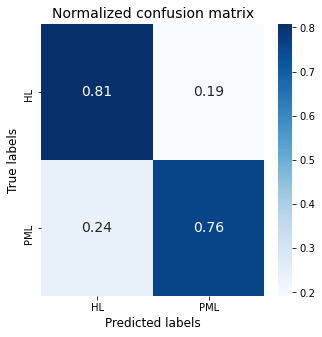

In [14]:
best_params = study_logistic . best_params

clf_logistic = LogisticRegression ( 
                                    penalty = "l2" ,
                                    class_weight = best_params["c_weights"] ,
                                    solver = best_params["solver"] ,
                                    max_iter = best_params["max_iter"] ,
                                    multi_class = "ovr" ,
                                  )

scores = cross_val_score ( clf_logistic, X_train, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_logistic, X_train, y_train, cv = 3 )

display_score ( model_name = "Logistic Regression", scores = scores )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True, normalization = True )

### Features ranking

In [15]:
from sklearn.feature_selection import RFECV

selector = RFECV ( clf_logistic, step = 1, cv = 3 )
selector . fit ( X_train, y_train )

RFECV(cv=3,
      estimator=LogisticRegression(class_weight='balanced', max_iter=979,
                                   multi_class='ovr', solver='liblinear'))

In [16]:
ranks = selector . ranking_
high_ranked_feats = np.nonzero ( ranks == 1 ) [0]

print ( "+-------------------+" )
print ( "|  Ranked Features  |" )
print ( "+-------------------+" )
for rnk, feat in zip (ranks, X_cols):
  print ( "| Rank-{:02} : {}" . format (rnk, feat) )
print ( "+--- - -" )

X_train_hrf = X_train [:,high_ranked_feats]

+-------------------+
|  Ranked Features  |
+-------------------+
| Rank-15 : age
| Rank-09 : SUVmin (SUV)
| Rank-01 : SUVmean (SUV)
| Rank-07 : MTV (# vx)
| Rank-12 : SMTV (mL/Kg) TOT
| Rank-08 : CONVENTIONAL_SUVbwmin
| Rank-06 : CONVENTIONAL_SUVbwKurtosis
| Rank-05 : DISCRETIZED_HISTO_Kurtosis
| Rank-13 : SHAPE_Sphericity[onlyFor3DROI])
| Rank-04 : GLCM_Correlation
| Rank-01 : GLRLM_SRE
| Rank-01 : NGLDM_Coarseness
| Rank-10 : NGLDM_Busyness
| Rank-11 : GLZLM_LZE
| Rank-14 : GLZLM_LZLGE
| Rank-02 : GLZLM_LZHGE
| Rank-03 : GLZLM_ZLNU
+--- - -


## Random Forest

+----------------------------+
|  Random Forest Classifier  |
+----------------------------+
| Accuracy : [0.88       0.79166667 0.91666667]
| Mean : 86.3%
| Std  : 5.2%
+--- - -
+---->  Label HL   <----+
|   Precision : 85.7%   |
|   Recall    : 92.3%   |
+---->  Label PML  <----+
|   Precision : 76.5%   |
|   Recall    : 61.9%   |
+-----------------------+


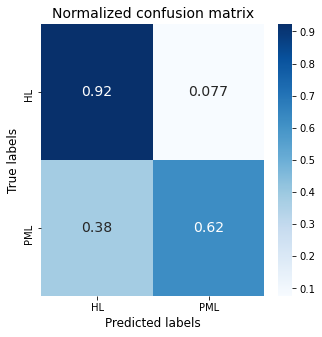

In [17]:
from sklearn.ensemble import RandomForestClassifier

clf_forest = RandomForestClassifier (
                                      n_estimators = 100 ,
                                      criterion = "gini" ,
                                      max_features = "sqrt" ,
                                      max_leaf_nodes = 10 ,
                                      max_depth = 5 ,
                                      class_weight = "balanced" ,
                                    )

scores = cross_val_score ( clf_forest, X_train_hrf, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_forest, X_train_hrf, y_train, cv = 3 )

display_score ( model_name = "Random Forest Classifier", scores = scores )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True, normalization = True )

### Automatic hyperparameters tuning

In [18]:
def obj_forest (trial):
  n_estims  = trial . suggest_int ( "n_estims", 50, 500, log = True )
  criterion = trial . suggest_categorical ( "criterion", ["gini", "entropy"] )
  max_feats = trial . suggest_categorical ( "max_feats", ["sqrt", "log2", None] )
  max_leaf  = trial . suggest_int ( "max_leaf" , 2, 20 )
  max_depth = trial . suggest_int ( "max_depth", 1, 10 )
  c_weights = trial . suggest_categorical ( "c_weights", ["balanced", "balanced_subsample", None] )

  model = RandomForestClassifier ( 
                                   n_estimators = n_estims ,
                                   criterion = criterion   ,
                                   max_features = max_feats  ,
                                   max_leaf_nodes = max_leaf ,
                                   max_depth = max_depth ,
                                   class_weight = c_weights ,
                                 )
  
  y_pred  = cross_val_predict ( model, X_train_hrf, y_train, cv = 3 )
  precision, recall = precision_recall_scores ( y_train, y_pred )

  weights = np.array ( [ 1 - ratio_train, ratio_train ] )
  scores  = recall
  
  return np.sum ( scores / weights ) / np.sum ( 1 / weights )


study_forest = optuna_study (
                              model_name  = "clf_forest"  ,
                              storage_dir = "./storage" ,
                              objective = obj_forest ,
                              n_trials  = 50 ,
                              direction = "maximize" ,
                              load_if_exists = False ,
                            )

In [19]:
df = study_forest . trials_dataframe ( attrs = ("params", "value") )
df . sort_values ( by = "value", ascending = False ) . head()

,params_c_weights,params_criterion,params_max_depth,params_max_feats,params_max_leaf,params_n_estims,value
0,balanced,entropy,3,None,16,224,0.741829
37,balanced,gini,1,sqrt,10,136,0.741829
27,balanced,entropy,6,log2,20,63,0.741829
28,balanced,entropy,3,log2,20,276,0.741829
29,balanced,entropy,8,log2,12,73,0.741829


+----------------------------+
|  Random Forest Classifier  |
+----------------------------+
| Accuracy : [0.8   0.75  0.875]
| Mean : 80.8%
| Std  : 5.1%
+--- - -
+---->  Label HL   <----+
|   Precision : 86.5%   |
|   Recall    : 86.5%   |
+---->  Label PML  <----+
|   Precision : 66.7%   |
|   Recall    : 66.7%   |
+-----------------------+


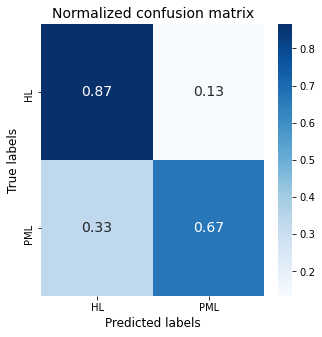

In [20]:
best_params = study_forest . best_params

clf_forest = RandomForestClassifier (
                                      n_estimators = best_params["n_estims"] ,
                                      criterion = best_params["criterion"]   ,
                                      max_features = best_params["max_feats"]  ,
                                      max_leaf_nodes = best_params["max_leaf"] ,
                                      max_depth = best_params["max_depth"] ,
                                      class_weight = best_params["c_weights"] ,
                                    )

scores = cross_val_score ( clf_forest, X_train_hrf, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_forest, X_train, y_train, cv = 3 )

display_score ( model_name = "Random Forest Classifier", scores = scores )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True, normalization = True )

## Gradient Boosted Decision Trees

+-------------------+
|  GBDT Classifier  |
+-------------------+
| Accuracy : [0.8        0.625      0.79166667]
| Mean : 73.9%
| Std  : 8.1%
+--- - -
+---->  Label HL   <----+
|   Precision : 83.0%   |
|   Recall    : 84.6%   |
+---->  Label PML  <----+
|   Precision : 60.0%   |
|   Recall    : 57.1%   |
+-----------------------+


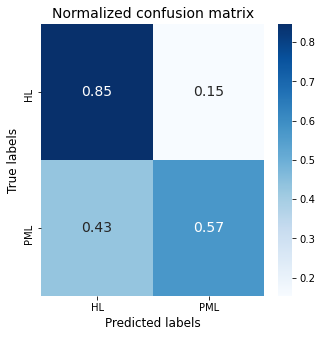

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gbdt = GradientBoostingClassifier (
                                        loss = "deviance" ,
                                        learning_rate = 0.3 ,
                                        n_estimators  = 100 ,
                                        criterion = "friedman_mse" ,
                                        max_features  = None , 
                                        max_leaf_nodes = 10 ,
                                        max_depth = 5       ,
                                      )

scores = cross_val_score ( clf_gbdt, X_train_hrf, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_gbdt, X_train, y_train, cv = 3 )

display_score ( model_name = "GBDT Classifier", scores = scores )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True, normalization = True )

### Automatic hyperparameters tuning

In [22]:
def obj_gbdt (trial):
  loss = trial . suggest_categorical ( "loss", ["deviance", "exponential"] )
  lr   = trial . suggest_float ( "lr", 0.05, 0.95, log = True )
  n_estims  = trial . suggest_int ( "n_estims", 50, 500, log = True )
  criterion = trial . suggest_categorical ( "criterion", ["friedman_mse", "mse"] )
  max_feats = trial . suggest_categorical ( "max_feats", ["sqrt", "log2", None] )
  max_leaf  = trial . suggest_int ( "max_leaf" , 2, 20 )
  max_depth = trial . suggest_int ( "max_depth", 1, 10 )

  model = GradientBoostingClassifier ( 
                                       loss = loss ,
                                       learning_rate =  lr , 
                                       n_estimators  =  n_estims , 
                                       criterion  =  criterion   ,
                                       max_features  = max_feats , 
                                       max_leaf_nodes = max_leaf ,
                                       max_depth = max_depth ,
                                     )
  
  y_pred  = cross_val_predict ( model, X_train_hrf, y_train, cv = 3 )
  precision, recall = precision_recall_scores ( y_train, y_pred )

  weights = np.array ( [ 1 - ratio_train, ratio_train ] )
  scores  = recall
  
  return np.sum ( scores / weights ) / np.sum ( 1 / weights )


study_gbdt = optuna_study (
                          model_name  = "clf_gbdt"  ,
                          storage_dir = "./storage" ,
                          objective = obj_gbdt ,
                          n_trials  = 50 ,
                          direction = "maximize" ,
                          load_if_exists = False ,
                        )

In [23]:
df = study_gbdt . trials_dataframe ( attrs = ("params", "value") )
df . sort_values ( by = "value", ascending = False ) . head()

,params_criterion,params_loss,params_lr,params_max_depth,params_max_feats,params_max_leaf,params_n_estims,value
0,mse,exponential,0.098153,1,sqrt,9,273,0.682375
37,mse,exponential,0.174701,5,None,4,113,0.682375
27,mse,exponential,0.309303,3,sqrt,16,256,0.682375
28,mse,exponential,0.053274,1,sqrt,19,338,0.682375
29,mse,exponential,0.476165,1,sqrt,20,453,0.682375


+-------------------+
|  GBDT Classifier  |
+-------------------+
| Accuracy : [0.8   0.75  0.875]
| Mean : 80.8%
| Std  : 5.1%
+--- - -
+---->  Label HL   <----+
|   Precision : 84.6%   |
|   Recall    : 84.6%   |
+---->  Label PML  <----+
|   Precision : 61.9%   |
|   Recall    : 61.9%   |
+-----------------------+


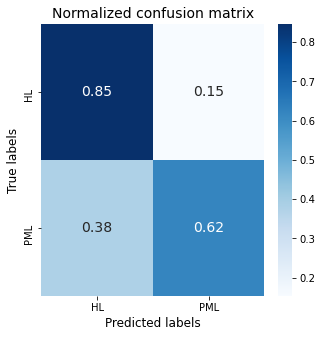

In [24]:
best_params = study_gbdt . best_params

clf_gbdt = GradientBoostingClassifier (
                                        loss = best_params["loss"] ,
                                        learning_rate = best_params["lr"] ,
                                        n_estimators  = best_params["n_estims"]  ,
                                        criterion  =  best_params["criterion"]   ,
                                        max_features  = best_params["max_feats"] ,
                                        max_leaf_nodes = best_params["max_leaf"] ,
                                        max_depth = best_params["max_depth"] ,
                                      )

scores = cross_val_score ( clf_gbdt, X_train_hrf, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_gbdt, X_train, y_train, cv = 3 )

display_score ( model_name = "GBDT Classifier", scores = scores )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True, normalization = True )

## Models combination

+----------------------+
|  Models combination  |
+----------------------+
| Accuracy : [0.84       0.79166667 0.875     ]
| Mean : 83.6%
| Std  : 3.4%
+--- - -
+---->  Label HL   <----+
|   Precision : 88.7%   |
|   Recall    : 90.4%   |
+---->  Label PML  <----+
|   Precision : 75.0%   |
|   Recall    : 71.4%   |
+-----------------------+


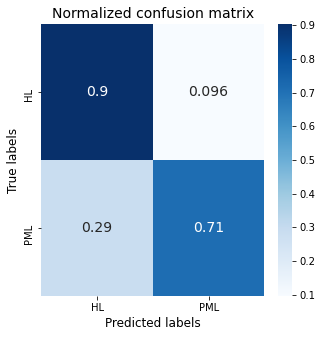

In [25]:
from sklearn.ensemble import VotingClassifier

clf_ens = VotingClassifier (
                             estimators = [ ("logistic", clf_logistic), ("forest", clf_forest), ("GBDT", clf_gbdt) ],
                             voting = "soft"
                           )

scores = cross_val_score ( clf_ens, X_train_hrf, y_train, scoring = "accuracy", cv = 3 )
y_train_pred = cross_val_predict ( clf_ens, X_train_hrf, y_train, cv = 3 )

display_score ( model_name = "Models combination", scores = scores )
_ = precision_recall_scores ( y_train, y_train_pred, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True, normalization = True )

## Model evaluation

+---------------+
|  Final model  |
+---------------+
| Accuracy : [0.85714286 0.5        0.83333333]
| Mean : 73.0%
| Std  : 16.3%
+--- - -
+---->  Label HL   <----+
|   Precision : 88.7%   |
|   Recall    : 90.4%   |
+---->  Label PML  <----+
|   Precision : 75.0%   |
|   Recall    : 71.4%   |
+-----------------------+


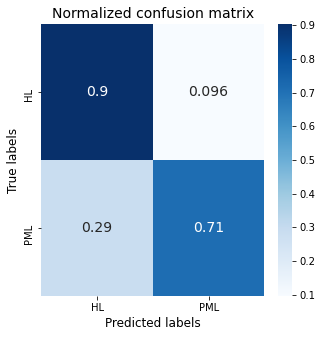

In [26]:
model = clf_logistic

scores = cross_val_score ( model, X_test, y_test, scoring = "accuracy", cv = 3 )
y_test_pred = cross_val_predict ( model, X_test, y_test, cv = 3 )

display_score ( model_name = "Final model", scores = scores )
_ = precision_recall_scores ( y_test, y_test_pred, verbose = True, labels = ["HL", "PML"], show_conf_matrix = True, normalization = True )

## Model export

In [27]:
model_dir = "./models"
exp_model_file = "binary_classifier_v1.pkl"
exp_model_path = os.path.join ( model_dir, exp_model_file )

pickle . dump ( model, open ( exp_model_path, "wb" ) )